# Converting a Normal EPANET .inp File to a PSV IWS File [1]
This notebook takes an input EPANET files with demands input normally as a CWS base demand and adds the necessary elements to convert it into a Pressure-Sustaining Valve (PSV) method IWS simulation  
For details on the PSV method refer to [1]  
A simplified schematic of the modified demand node in PSV is seen below:  
  
  
  
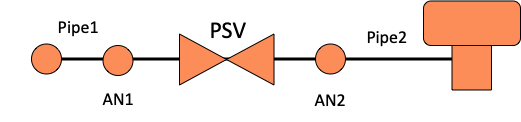

### First, we import the necessary libraries and packages
**WNTR** for building EPANET network models in Python  
**NUMPY & PANDAS** for data handling and processing  
**re** for searching and matching text in the .inp file using regular expressions

In [135]:
import wntr  
import numpy as np 
import pandas as pd
import re

### Specifying paths for simulation files and preprocessing the input
**Warning:** *Paths in this script (and the rest of this repo) are absolute*  
Input filename (with extensions) as string.  

In [136]:
 # Replace with appropriate path and filename
directory='/Users/omaraliamer/Desktop/UofT/Papers/Github/IWS-Modelling-Methods-Repo/Network-Files/Network 2/'
filename='Network2_12hr_PDA.inp'
name_only=filename[0:-7]
print("Selected File: ",name_only)
abs_path=directory+filename

Selected File:  Network2_12hr_


### Necessary Assumptions Input
Converting a CWS demand-driven analysis into an IWS pressure-driven analysis requires some assumptions in all methods  
The resistance of the service connection between the demand node and the household (end-user) is uncertain and is modelled using two assumptions  
The **desired head (pressure)** is the pressure at the demand node at which (or above) the consumer can satisfy their full demand in the supply duration (or possible less)  
The **minimum head (pressure)** is the minimum pressure at the demand node required for flow to begin passing through the service connection  
These two assumptions dictate the flow-pressure relationship that determines the pressure-dependent flow through the service connection as follows:

$$ Q\, = \!Q_{des}\sqrt{\frac{H_{j}-H^{min}}{H^{des}-H^{min}}} \quad[2]$$ 
Where Q is the flow through the service connection, $Q_{des}$ is the desired (base) demand, $H_j$ is the head at the demand node $j$, $H^{min}$ is the minimum head, and $H^{des}$ is the desired head


In [137]:
desired_pressure=10     # Set the desired pressure
minimum_pressure=0      # Set the minimum pressure
pressure_diff=desired_pressure-minimum_pressure  

### Extracting information from the input file
To modify the .inp file, demand node IDs, elevations, x and y coordinates  
We use wntr to build the network model of the input file and use wntr's junctions module to extract the details of each node

In [138]:
demand_nodes=[]       # For storing list of nodes that have non-zero demands
desired_demands=[]    # For storing demand rates desired by each node for desired volume calculations
elevations=[]         # For storing elevations of demand nodes
xcoordinates=[]       # For storing x coordinates of demand nodes
ycoordinates=[]       # For storing y coordinates of demand nodes
all_nodes=[]          # For storing list of node ids of all nodes
all_elevations=[]     # For storing elevations of all nodes
## MAYBE SAVE ALL NODE IDS IN DATAFRAME WITH ELEVATION AND BASE DEMAND AND THEN FILTER DATA FRAME LATER FOR DEMAND NODES ONLY

# Creates a network model object using EPANET .inp file
network=wntr.network.WaterNetworkModel(abs_path)

# Iterates over the junction list in the Network object
for node in network.junctions():
    all_nodes.append(node[1].name)
    all_elevations.append(node[1].elevation)
    # For all nodes that have non-zero demands
    if node[1].base_demand != 0:
        # Record node ID (name), desired demand (base_demand) in CMS, elevations, x and y coordinates
        demand_nodes.append(node[1].name)
        desired_demands.append(node[1].base_demand)
        elevations.append(node[1].elevation)
        xcoordinates.append(node[1].coordinates[0])
        ycoordinates.append(node[1].coordinates[1])

# Get the supply duration in minutes (/60) as an integer
supply_duration=int(network.options.time.duration/60)

### Writing Tank Section
Each Simple Tank represents the demand volume of the respective demand node throughout the supply cycle  
The volume of each Simple Tank is calculated is:  
$$ V_{des}\,=\,Q_{des}\,(m^3/s)\,\times\,60\,(s/min)\,\times\,Supply\,Duration\,(min)$$  
Using the desired volume, and unifying tank height at 1 m (for ease of postprocessin), the diameter of the tank can be calculated as:  
$$D\,(m)\,=\sqrt{\frac{4V_{des}}{\pi}}$$

In [139]:
# Adds the phrase TankforNode to each node id and stores it as a tank id
tankids=['ATforNode'+str(id) for id in demand_nodes] 
# Calculate desired demand volumes and then calculates the diameters of the simple tanks
volumes=[demand* 60 * supply_duration for demand in desired_demands]
diameters_tanks=[round(np.sqrt(volume * 4 / np.pi),4) for volume in volumes]
# Calculates the elevations of the ATs as the elevation of their original demand node - 1 m
tank_elevations=[elevation-1 for elevation in elevations]
# List of zeros for each tank to be used as the values for Initial Level, Minimum Level, and Minimum Volume 
zeros=[0.0000] *len(tankids)
# Sets Maximum levels for all tanks as 1
MaxLevel=[1.0000]*len(tankids)
# No Volume curve is assigned to any of the tanks
VolCurve=['    ']*len(tankids)
# Semicolons to end each tank line
semicolons=[';']*len(tankids)
# Assemble all lists into a dataframe where each row is the definition for one simple tank
# Required fields in EPANET .inp [ID   Elevation   InitLevel   MinLevel   MaxLevel    Diameter   MinVol    VolCurve   ;]
tanks_section=pd.DataFrame(list(zip(tankids,tank_elevations,zeros,zeros,MaxLevel,diameters_tanks,zeros,VolCurve,semicolons)))
# Exports the tank section as a list of strings where each entry is a line of the tanks section
added_tanks=tanks_section.to_string(header=False,index=False,col_space=10).splitlines()

### Writing Artificial Nodes
As seen in the figure above, each demand nodes will require the addition of two Artificial Nodes (AN) to connect it to the PSV and the downstream tank  
Both nodes will be at the same elevation of the demand node, will have no demand assigned, and no demand patterns  
The first node for a demand node X will be named AN1forNodeX and the second will be AN2forNodeX

In [140]:
# Adds the phrase "AN1forNode" to each node id as the id of the first artificial node (AN) added to each demand node
node1ids=["AN1forNode"+str(id) for id in demand_nodes]
# Adds the phrase "AN2forNode" to each node id as the id of the second artificial node (AN) added to each demand node
node2ids=["AN2forNode"+str(id) for id in demand_nodes]
# Sets the base demand for all added nodes as 0
base_demands=[0]*len(node1ids)
# No demand pattern is assigned to any demand node
demand_patterns=["     "]*len(node1ids)
# Dataframe with all the required fields for AN1 [ID   Elevation   Demand   Pattern   ;]
nodes1=pd.DataFrame(list(zip(node1ids,elevations,base_demands,demand_patterns,semicolons)))
# Dataframe with all the required fields for AN2 [ID   Elevation   Demand   Pattern   ;]
nodes2=pd.DataFrame(list(zip(node2ids,elevations,base_demands,demand_patterns,semicolons)))
# Joins both dataframes into one dataframe with all the added nodes
added_nodes=pd.concat([nodes1,nodes2])
# Exports the added junctions section as a list of strings where each entry is a line of the junctions section
added_nodes=added_nodes.to_string(header=False,index=False,col_space=10).splitlines()

### Writing Added Pipes
Similar to the tanks section, each field for the pipe entries is stored in a separate list  
PSV method requires the addition of two pipes (Refer to the above figure)  
Both pipes according to [1] should have a small length (0.1 m), a diameter of 350 mm, a HW coefficient of 130, and a minor loss coefficient of:  
$$ K_{Minor}=(H^{des}-H^{min})\frac{g\pi^2D^4}{8Q_{des}^2}$$
The diameter is unified at 0.35 m for simplicity (350 mm)  
While the second pipe will have a minor loss coefficient of 0, and serves to connect the PSV to the downstream artificial tank  


In [141]:
# Adds the phrase PipeforNode to each node id and stores it as a pipe id
pipeids=['Pipe1forNode'+str(id) for id in demand_nodes]
length=len(pipeids)
pipeids.extend(['Pipe2forNode'+str(id) for id in demand_nodes])
# From nodes
from_node=demand_nodes+node2ids
# to nodes
to_node=node1ids+tankids
# Calculates the minor loss coefficient of each pipe to simulate the head-flow relationship
minorloss=[round( pressure_diff*9.81*np.pi**2*0.35**4/(8*demand**2) , 4) for demand in desired_demands]
minorloss.extend([0]*length)
# Sets all lengths to 0.1 m
lengths=[0.1]*len(pipeids)
# Sets all diameters to 1 m (1000 mm)
diameters_pipes=[350]*len(pipeids)
# Sets all Hazen-Williams Coefficients as 130
hazen=[130]*len(pipeids)
# Sets all created pipes to work as Check Valved to prevent backflow
status=['CV']*len(pipeids)
# list of semicolons
semicolons=[";"]*len(pipeids)
# Assemble all lists into a dataframe where each row is the definition for one simple tank
# Data frame with all required fields [ID   Node1   Node2   Length   Diameter   Roughness   MinorLoss   Status   ;]
added_pipes=pd.DataFrame(list(zip(pipeids,from_node,to_node,lengths,diameters_pipes,hazen,minorloss,status,semicolons)))
# Exports the pipe section as a list of strings where each entry is a line of the pipes section
added_pipes=added_pipes.to_string(header=False,index=False,col_space=10).splitlines()

### Writing Valves Section
For each original demand node, a Pressure-Sustaining Valve is added to maintain the upstream pressure (at AN1) at 0 to simulate the free outlet condition of a tank filling from the top  


In [142]:
# Adds the phrase APSVforNode to each node id and stores it as a PSV valve id
valveids=["APSVforNode"+str(id) for id in demand_nodes]
# From nodes are the first artificial nodes (node1ids) and to nodes are the second artificial nodes (node2ids)
# Sets all valve diameters to 12 (will not affect head loss across valve)
valve_diameters=[12.0000]*len(valveids)
# Sets the type of all valves to Pressure-Sustaining Valves
valve_types=["PSV"]*len(valveids)
# Sets the valve setting (the pressure to sustain upstream of the valve in this case) to 0 (Atmospheric pressure to simulate a tank filling from the top)
valve_settings=["0.0000"]*len(valveids)
# Sets the minor loss coefficient across the valve to 0
valve_minor_loss=["0.0000"]*len(valveids)
# Semicolons at the end of each line
semicolons=[';']*len(valveids)
# Data frame with all required fields [ID   Node1   Node2   Diameter   Type   Setting   MinorLoss   ;]
added_valves=pd.DataFrame(list(zip(valveids,node1ids,node2ids,valve_diameters,valve_types,valve_settings,valve_minor_loss,semicolons)))
added_valves=added_valves.to_string(header=False,index=False,col_space=10).splitlines()

### Writing Tank & AN Coordinates  
Each tank's coordinates are translated by a XX m in both x and y directions  
The ANs will be translated YY and ZZ meters respectively in both directions  
These coordinates are merely for display and do not affect the simulation in any way  
[SCALE THESE VALUES FOR BETTER DISPLAY BASED ON YOUR INPUT FILE SCALE]

In [143]:
# Set preferred translation distance for [AN1,AN2,AT] where AN is Artificial Node and AT is the Artifical Tank
x_direct_distance=[20,40,60]
y_driect_distance=[-20,0,-20]
# Translates the tanks by a 100 m in both axes 
node1_xcoord=[x+x_direct_distance[0] for x in xcoordinates]
node2_xcoord=[x+x_direct_distance[1] for x in xcoordinates]
tank_xcoord =[x+x_direct_distance[2] for x in xcoordinates]
node1_ycoord=[y+y_driect_distance[0] for y in ycoordinates]
node2_ycoord=[y+y_driect_distance[1] for y in ycoordinates]
tank_ycoord =[y+y_driect_distance[2] for y in ycoordinates]

added_xcoordinates=node1_xcoord+node2_xcoord+tank_xcoord
added_ycoordinates=node1_ycoord+node2_ycoord+tank_ycoord
ids_coords=node1ids+node2ids+tankids

# Assemble all lists into a dataframe where each row is the coordinates for one simple tank
added_coordinates=pd.DataFrame(list(zip(ids_coords,added_xcoordinates,added_ycoordinates)))
# Exports the coordinate section as a list of strings where each entry is a line of the coordinates section
added_coordinates=added_coordinates.to_string(header=False,index=False,col_space=10).splitlines()

### Rewriting Base Demands
After creating the required additions to the original demand nodes, the base demands for all demand junctions has to be reset to zero

In [144]:
# List of zero base demands for all nodes
zerodemands=[0]*len(all_nodes)
# White space indicating no patterns
pattern=['     ']*len(all_nodes)
semicolons=[';']*len(all_nodes)
original_nodes=pd.DataFrame(list(zip(all_nodes,all_elevations,zerodemands,pattern,semicolons)))
original_nodes=original_nodes.to_string(header=False,index=False,col_space=10).splitlines()

In [145]:
# opens .inp file to read
file=open(abs_path,'r')
lines=[]            # list to store all lines in the .inp file
linecount=0         # Counter for the number of lines
junctions_marker=0  # To store the line number at which the junctions section starts
tanks_marker=0      # To store the line number at which the tanks section starts
pipes_marker=0      # To store the line number at which the pumps section starts
valves_marker=0     # to store the line number at which the valves section
coords_marker=0     # To store the line number at which the vertices section starts

# Loops over each line in the input file 
for line in file:
    # Record the position of the phrase [JUNCTIONS] and add 2 to skip the header line
    if re.search('\[JUNCTIONS\]',line):
        junctions_marker=linecount+2
    # Record the position of the phrase [TANKS] and add 2 to skip the header line
    if re.search('\[TANKS\]',line):
        tanks_marker=linecount+2
     # Record the position of the phrase [PUMPS] and subtract 1 to add pipes to the end of the pipe section
    if re.search('\[PUMPS\]',line):
        pipes_marker=linecount-1
    # Record the position of the phrase [VALVES] and add 2 to skip the header line
    if re.search('\[VALVES\]',line):
        valves_marker=linecount+2
     # Record the position of the phrase [Vertices] and subtract 1 to add Tank cooridnates to the end of the coordinates section
    if re.search('\[VERTICES\]',line):
        coords_marker=linecount-1
    linecount+=1
    # Store all lines in a list
    lines.append(line)
file.close()

# Translate the tanks marker by the length of the added nodes (ANs) that will be added before it (as it will displace all subsequent lines)
tanks_marker+=len(added_nodes)
# Translate the pipes marker by the length of the tank section that will be added before it (as it will displace all subsequent lines)
pipes_marker+=len(added_tanks)+len(added_nodes)
# Translate the coordinates marker by the length of the added tanks, pipes and valves
valves_marker+=len(added_tanks)+len(added_pipes)+len(added_nodes)
# Translate the coordinates marker by the length of the added tanks, pipes and valves
coords_marker+=len(added_tanks)+len(added_pipes)+len(added_valves)+len(added_nodes)

# Inserts the created sections in their appropriate location in the list of lines
lines[junctions_marker:junctions_marker+len(original_nodes)]=original_nodes
lines[junctions_marker+len(original_nodes):junctions_marker+len(original_nodes)]=added_nodes
lines[tanks_marker:tanks_marker]=added_tanks
lines[pipes_marker:pipes_marker]=added_pipes
lines[valves_marker:valves_marker]=added_valves
lines[coords_marker:coords_marker]=added_coordinates

# Opens a new file in the same directory to write the modified network .inp file in
file=open(directory+name_only+'PSV.inp','w')
c=0     #line counter

# All lines added by this script are missing a new line character at the end, the conditional statements below add the new line character for these lines only and writes all lines to the file
for line in lines:
    if c>=junctions_marker and c<=junctions_marker+len(original_nodes)+len(added_nodes):
        file.write(line+'\n')
    elif c>=tanks_marker and c<=tanks_marker+len(added_tanks):
        file.write(line+'\n')
    elif c>=pipes_marker and c<=pipes_marker+len(added_pipes):
        file.write(line+'\n')
    elif c>=valves_marker and c<=valves_marker+len(added_valves):
        file.write(line+'\n')
    elif c>=coords_marker and c<=coords_marker+len(added_coordinates):
        file.write(line+'\n')
    else: file.write(line)    
    c+=1
file.close()


### References:
##### [1] P. Sivakumar, N. B. Gorev, T. T. Tanyimboh, I. F. Kodzhespirova, C. R. Suribabu, and T. R. Neelakantan, “Dynamic Pressure-Dependent Simulation of Water Distribution Networks Considering Volume-Driven Demands Based on Noniterative Application of EPANET 2,” Journal of Water Resources Planning and Management, vol. 146, no. 6, p. 06020005, Jun. 2020, doi: 10.1061/(asce)wr.1943-5452.0001220.
##### [2] B. M. Janet Wagner, U. Shamir, and D. H. Marks, “WATER DISTRIBUTION RELIABILITY: SIMULATION METHODS.”